# Data Pre-Processing

In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from ucimlrepo import fetch_ucirepo
import data_handler as dh

In [43]:
bank_marketing = fetch_ucirepo(id=222)
X_bank_marketing, y_bank_marketing = bank_marketing.data.features, bank_marketing.data.targets

wine_quality = fetch_ucirepo(id=186)
X_wine_quality, y_wine_quality = wine_quality.data.features, wine_quality.data.targets

We pre-process the bank marketing data like last week.

In [44]:
X_bank_marketing = X_bank_marketing.drop(['month', 'day_of_week'], axis=1)  # drop features without value for prediction

X_bank_marketing = X_bank_marketing.fillna(0)

X_bank_marketing = pd.get_dummies(X_bank_marketing).astype(np.float64)

X_bank_marketing = (X_bank_marketing - X_bank_marketing.min()) / (
        X_bank_marketing.max() - X_bank_marketing.min())  # normalize the data

y_bank_marketing = y_bank_marketing.copy()
y_bank_marketing['y'] = y_bank_marketing['y'].map({'no': 0, 'yes': 1})  # convert targets to numeric values

[Empty Markdown]

In [45]:
X_wine_quality = (X_wine_quality - X_wine_quality.min()) / (X_wine_quality.max() - X_wine_quality.min())
y_wine_quality = (y_wine_quality - y_wine_quality.min()) / (y_wine_quality.max() - y_wine_quality.min())

In [46]:
X_bank_train, X_bank_test, y_bank_train, y_bank_test = dh.split_data(X_bank_marketing, y_bank_marketing, 0.8)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = dh.split_data(X_wine_quality, y_wine_quality, 0.8)

# Regularization
We are going to implement Ridge Regression according to the SGD algorithm on exercise sheet 4. The only difference is that we use 50 samples at once.

## Ridge Gradient Descent
For the wine quality dataset, we implement a Ridge Regression model, with MSE as loss function:

$$
Loss = \frac{1}{n} \sum_{i=1}^{n} (y_i - (x_i \beta + b))^2 + \lambda \sum_{j=1}^{P} \beta_j^2
$$

The gradient with respect to $\beta$ is:

$$
\Delta_{\beta} Loss = - \frac{2}{n} X^T (y - X \beta) + 2 \lambda \beta
$$

The bias term gradient is:

$$
\Delta_{b} Loss = \frac{2}{n} \sum_{i=1}^n ((x_i \beta + b) - y_i)
$$



In [136]:
class RidgeRegression:
    def __init__(self):
        self.B = None
        self.bias = None

    def fit(self, X_train, y_train, X_test, y_test, initial_learning_rate, regularization_constant, i_max,
            batch_size=50, tolerance=1e-4, clip_value=10):
        n, d = X_train.shape
        self.B = np.zeros(d)
        self.bias = 0

        train_rmse_history = []
        test_rmse_history = []

        learning_rate = initial_learning_rate
        bold_driver_reward = 1.1
        bold_driver_penalty = 0.5

        for epoch in range(1, i_max + 1):
            indices = np.random.permutation(n)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            prev_rmse = None

            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_pred = (X_batch @ self.B) + self.bias

                gradient_B = -(2 / len(y_batch)) * X_batch.T @ (y_batch - y_pred) + 2 * regularization_constant * self.B
                gradient_bias = -(2 / len(y_batch)) * np.sum(y_batch - y_pred)

                # gradient clipping required to prevent overflows lol
                gradient_B_norm = np.linalg.norm(gradient_B)
                if gradient_B_norm > clip_value:
                    gradient_B = (gradient_B / gradient_B_norm) * clip_value

                gradient_bias_norm = np.linalg.norm(gradient_bias)
                if gradient_bias_norm > clip_value:
                    gradient_bias = (gradient_bias / gradient_bias_norm) * clip_value

                B_prev = self.B.copy()
                L2_prev = self.bias

                self.B -= learning_rate * gradient_B
                self.bias -= learning_rate * gradient_bias

                y_batch_pred = (X_batch @ self.B) + self.bias
                rmse_batch = np.sqrt(np.mean((y_batch - y_batch_pred) ** 2))

                # bold driver
                if prev_rmse is not None:
                    if rmse_batch < prev_rmse:
                        learning_rate *= bold_driver_reward
                    else:
                        self.B = B_prev
                        self.bias = L2_prev
                        learning_rate *= bold_driver_penalty

            y_train_pred = self.predict(X_train)
            y_test_pred = self.predict(X_test)
            rmse_train = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
            rmse_test = np.sqrt(np.mean((y_test - y_test_pred) ** 2))

            train_rmse_history.append(rmse_train)
            test_rmse_history.append(rmse_test)

            if np.linalg.norm(learning_rate * gradient_B) < tolerance:
                return train_rmse_history, test_rmse_history

        print(f'WARNING: Did not converge after {i_max} epochs!')
        return train_rmse_history, test_rmse_history

    def predict(self, X):
        return X @ self.B + self.bias

[Empty Markdown]

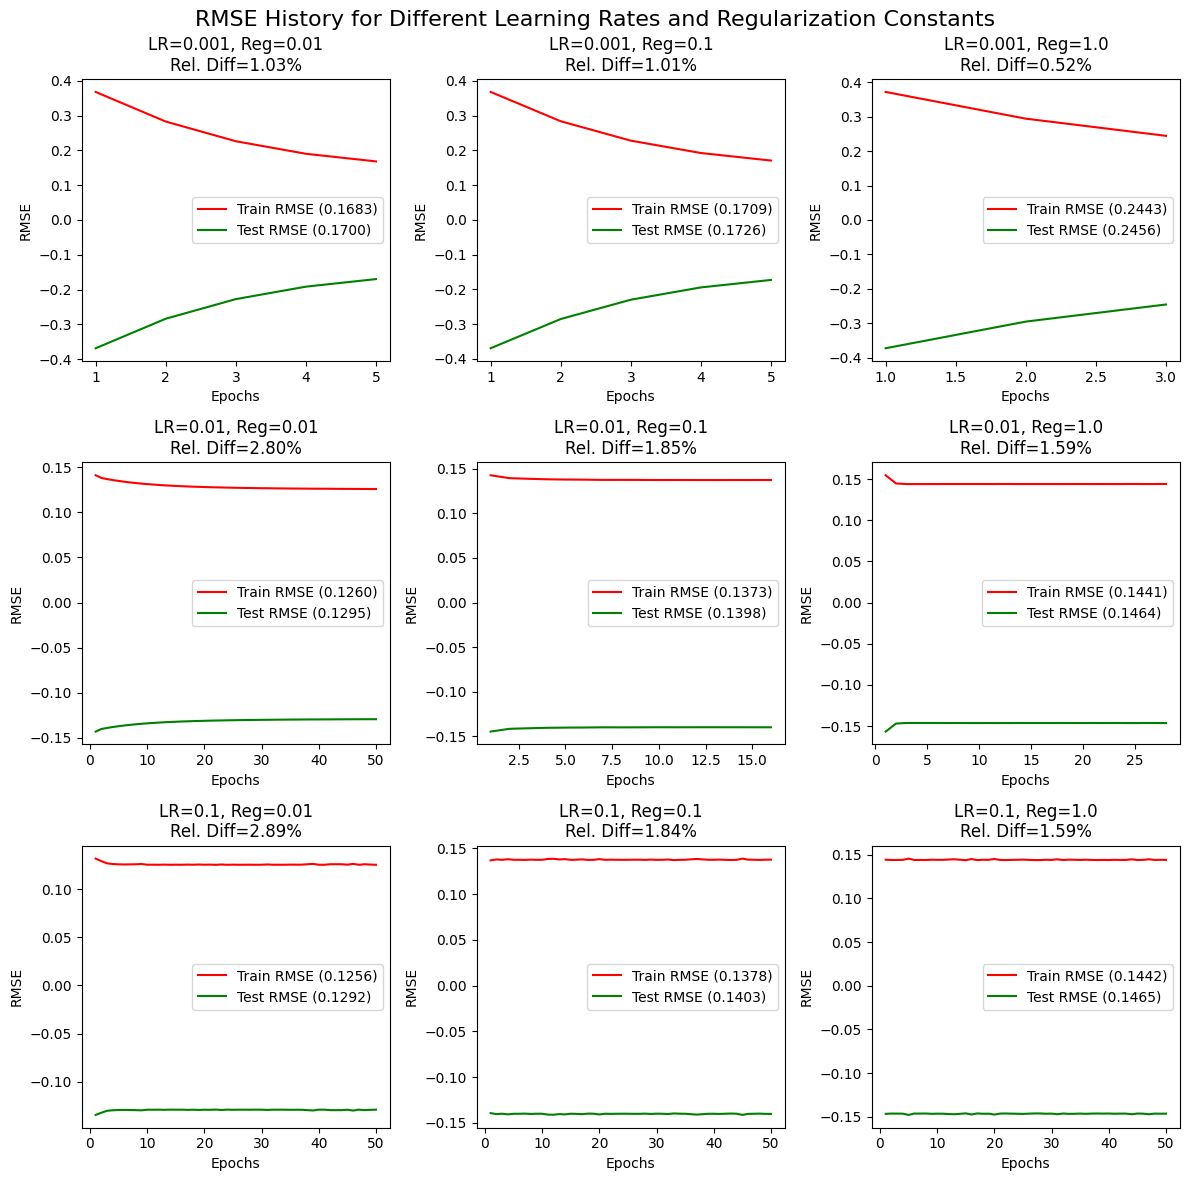

In [138]:
model = RidgeRegression()

learning_rates = [0.001, 0.01, 0.1]
reg_constants = [0.01, 0.1, 1.0]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('RMSE History for Different Learning Rates and Regularization Constants', fontsize=16)

final_test_rmse = []

for i, learning_rate in enumerate(learning_rates):
    for j, reg_constant in enumerate(reg_constants):
        ax = axes[i, j]
        train_rmse_history, test_rmse_history = model.fit(X_wine_train, y_wine_train, X_wine_test, y_wine_test,
                                                          initial_learning_rate=learning_rate,
                                                          regularization_constant=reg_constant, i_max=50)
        final_test_rmse.append(test_rmse_history[-1])

        relative_difference = abs(train_rmse_history[-1] - test_rmse_history[-1]) / train_rmse_history[-1]

        ax.plot(range(1, len(train_rmse_history) + 1), train_rmse_history,
                label=f'Train RMSE ({train_rmse_history[-1]:.4f})', color='red')
        ax.plot(range(1, len(test_rmse_history) + 1), -np.array(test_rmse_history),
                label=f'Test RMSE ({test_rmse_history[-1]:.4f})', color='green')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('RMSE')
        ax.set_title(f'LR={learning_rate}, Reg={reg_constant}\nRel. Diff={relative_difference:.2%}')
        ax.legend()

plt.tight_layout()
plt.show()
plt.close()

[Empty Markdown]

## Ridge Logistic Regression
Since the Bank dataset is a classification problem, we implement a Logistic Regression model. The model is given as $\hat{y}_n = \sigma(\beta^T x_n + b)$

We define the Loss function as:
$$
Loss = - \sum_{i=1}^{n} [y_i log(\sigma(x_i^T \beta + b)) + (1 - y_i) log(1 - \sigma(x_i^T \beta + b)) ] + \lambda \sum_{j=1}^{P} \beta_j^2
$$

With the gradient with respect to $\beta$:
$$
\Delta_{\beta} Loss = \frac{1}{n} X^T (\sigma(x_i^T \beta + b) - y) + 2 \lambda \beta
$$

And the gradient with respect to the bias:

$$
\Delta_{b} Loss = \frac{1}{n} \sum_{i=1}^n (\sigma(X_i \beta + b) - y_i)
$$

In [129]:
class RidgeLogisticRegression:
    def __init__(self):
        self.B = None
        self.bias = None

    def fit(self, X_train, y_train, X_test, y_test, initial_learning_rate, regularization_constant, i_max,
            batch_size=50, tolerance=1e-3, clip_value=10):
        n, d = X_train.shape
        self.B = np.zeros(d)
        self.bias = 0
        patience = 5
        patience_counter = 0
        best_loss = float('inf')

        train_loss_history = []
        test_loss_history = []

        learning_rate = initial_learning_rate

        for epoch in range(1, i_max + 1):
            indices = np.random.permutation(n)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_pred = 1 / (1 + np.exp(-(X_batch @ self.B + self.bias)))

                gradient_B = (1 / len(y_batch)) * X_batch.T @ (y_pred - y_batch) + 2 * regularization_constant * self.B
                gradient_bias = (1 / len(y_batch)) * np.sum(y_pred - y_batch)

                # Gradient clipping to prevent overflow
                gradient_B_norm = np.linalg.norm(gradient_B)
                if gradient_B_norm > clip_value:
                    gradient_B = (gradient_B / gradient_B_norm) * clip_value

                gradient_bias_norm = np.linalg.norm(gradient_bias)
                if gradient_bias_norm > clip_value:
                    gradient_bias = (gradient_bias / gradient_bias_norm) * clip_value

                self.B -= learning_rate * gradient_B
                self.bias -= learning_rate * gradient_bias

                # We use fixed step length in this model, since bold driver is just making trouble and i just can't figure out how to make it work (It is not a requirement of the task)

            train_loss = self._compute_loss(X_train, y_train, regularization_constant)
            test_loss = self._compute_loss(X_test, y_test, regularization_constant)

            train_loss_history.append(train_loss)
            test_loss_history.append(test_loss)

            # we use change in loss improvement as convergence criterion, since the model doesnt seem to improve much after a few iterations
            if abs(train_loss - best_loss) < tolerance:
                patience_counter += 1
            else:
                patience_counter = 0
                best_loss = train_loss

            if patience_counter >= patience:
                return train_loss_history, test_loss_history

        print(f'WARNING: Did not converge after {i_max} epochs!')
        return train_loss_history, test_loss_history

    def predict(self, X):
        return (1 / (1 + np.exp(-X @ self.B + self.bias)) >= 0.5).astype(np.int8)

    def _compute_loss(self, X, y, regularization_constant):
        y_pred = 1 / (1 + np.exp(-(X @ self.B + self.bias)))
        log_likelihood = -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
        regularization_term = regularization_constant * np.sum(self.B ** 2)
        return log_likelihood + regularization_term


[Empty Markdown]

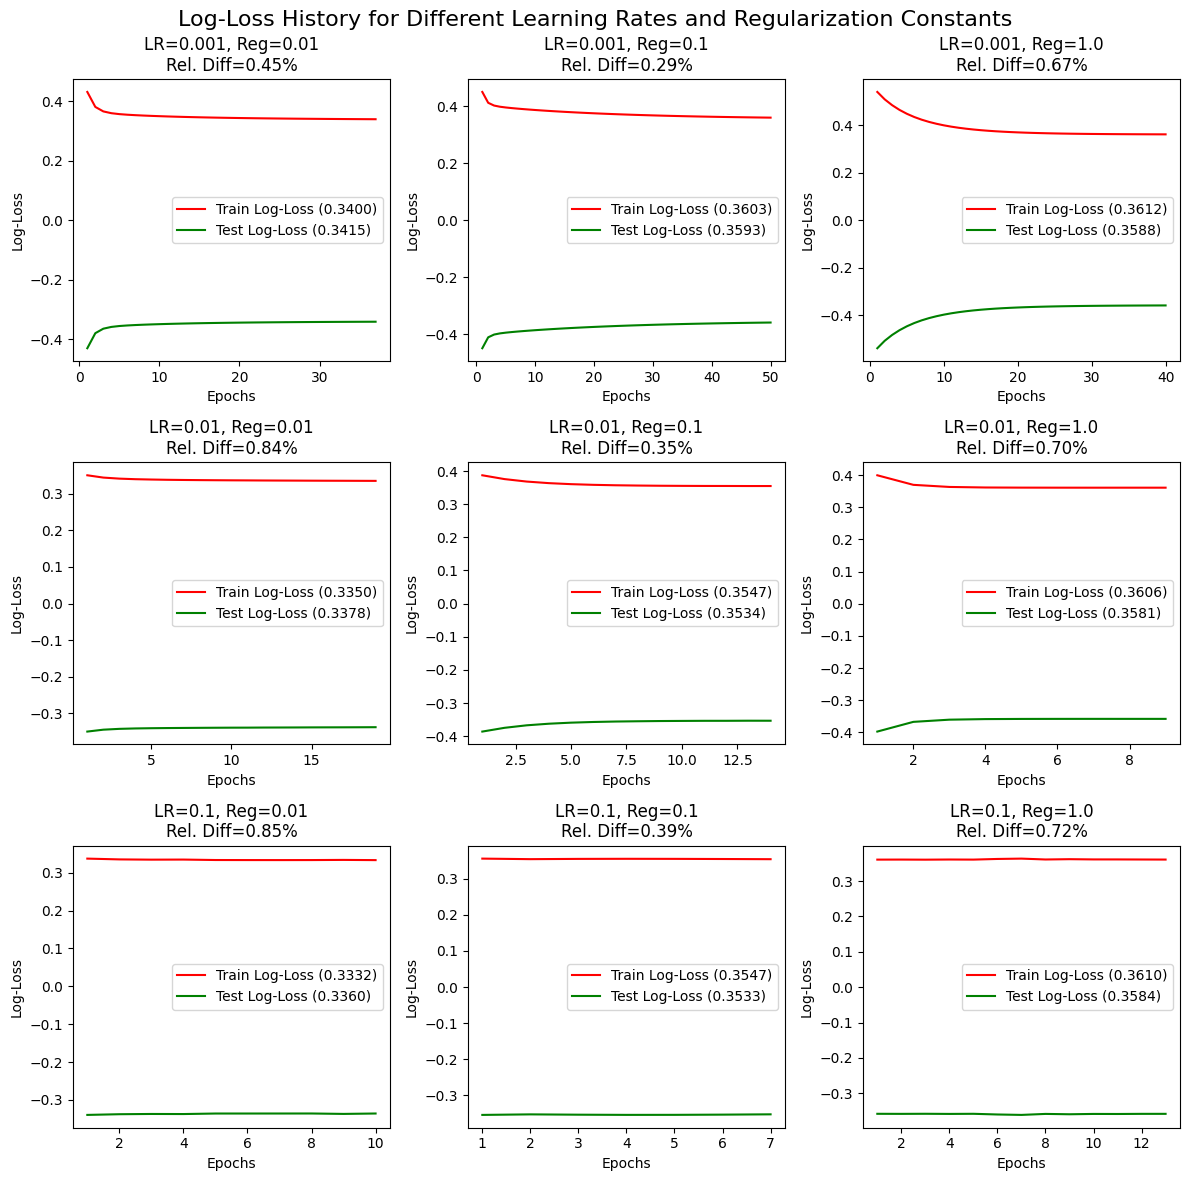

In [128]:
model = RidgeLogisticRegression()

learning_rates = [0.001, 0.01, 0.1]
reg_constants = [0.01, 0.1, 1.0]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Log-Loss History for Different Learning Rates and Regularization Constants', fontsize=16)

final_test_loss = []

for i, learning_rate in enumerate(learning_rates):
    for j, reg_constant in enumerate(reg_constants):
        ax = axes[i, j]

        train_loss_history, test_loss_history = model.fit(X_bank_train, y_bank_train, X_bank_test, y_bank_test,
                                                          initial_learning_rate=learning_rate,
                                                          regularization_constant=reg_constant, i_max=50)

        final_test_loss.append(test_loss_history[-1])

        relative_difference = abs(train_loss_history[-1] - test_loss_history[-1]) / train_loss_history[-1]

        ax.plot(range(1, len(train_loss_history) + 1), train_loss_history,
                label=f'Train Log-Loss ({train_loss_history[-1]:.4f})', color='red')
        ax.plot(range(1, len(test_loss_history) + 1), -np.array(test_loss_history),
                label=f'Test Log-Loss ({test_loss_history[-1]:.4f})', color='green')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Log-Loss')
        ax.set_title(f'LR={learning_rate}, Reg={reg_constant}\nRel. Diff={relative_difference:.2%}')
        ax.legend()

plt.tight_layout()
plt.show()
plt.close()

[Empty Markdown]

# Hyper-parameter Tuning
Now, we will implement the hyper-parameter tuning for both models.

## Ridge Gradient Descent

In [139]:
def k_fold_cross_validation(X, y, learning_rates, reg_cons, k=5, batch_size=50):
    fold_size = len(y) // k

    rmse_scores = np.zeros((len(learning_rates), len(reg_cons)))

    for lr_idx, lr in enumerate(learning_rates):
        for rc_idx, rc in enumerate(reg_cons):
            rmse_fold_history = []

            for fold in range(k):
                start = fold * fold_size
                end = start + fold_size

                X_test = X[start:end]
                y_test = y[start:end].ravel()
                X_train = np.concatenate([X[:start], X[end:]], axis=0)
                y_train = np.concatenate([y[:start], y[end:]], axis=0).ravel()

                model = RidgeRegression()
                _, test_rmse_history = model.fit(X_train, y_train, X_test, y_test, initial_learning_rate=lr,
                                                 regularization_constant=rc, i_max=200, batch_size=batch_size)

                rmse_fold_history.append(test_rmse_history[-1])

            rmse_scores[lr_idx][rc_idx] = np.mean(rmse_fold_history)

    return rmse_scores


learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
reg_cons = [0.0001, 0.001, 0.01, 0.1, 1]

rmse_scores = k_fold_cross_validation(X_wine_quality.to_numpy(), y_wine_quality.to_numpy(), learning_rates, reg_cons)


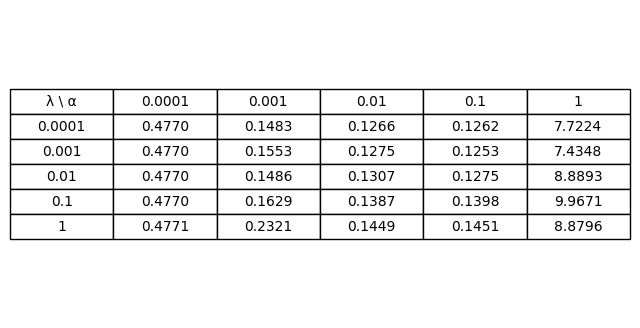

In [143]:
def display_rmse_table(rmse_scores, learning_rates, reg_cons):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('tight')
    ax.axis('off')

    table_data = [["λ \\ α"] + [str(lr) for lr in learning_rates]]
    for i, hp in enumerate(reg_cons):
        row = [str(hp)] + [f"{rmse_scores[j, i]:.4f}" for j in range(len(learning_rates))]
        table_data.append(row)

    table = ax.table(cellText=table_data, cellLoc='center', loc='center')
    table.scale(1, 1.5)

    plt.show()


display_rmse_table(rmse_scores, learning_rates, reg_cons)

[Empty Markdown] Describe the table

In [141]:
min_idx = np.unravel_index(np.argmin(rmse_scores), rmse_scores.shape)

best_learning_rate = learning_rates[min_idx[0]]
best_reg_cons = reg_cons[min_idx[1]]

print(f'Best Learning Rate: {best_learning_rate:.4f}')
print(f'Best Regularization Constant: {best_reg_cons:.4f}')

Best Learning Rate: 0.1000
Best Regularization Constant: 0.0010


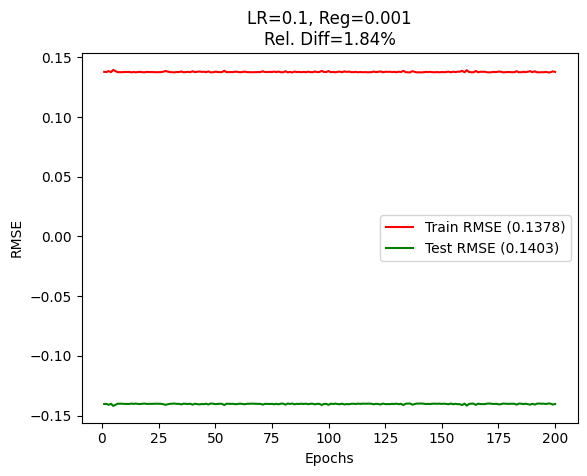

In [142]:
best_model = RidgeRegression()

best_train_rmse_history, best_test_rmse_history = best_model.fit(X_wine_train, y_wine_train, X_wine_test, y_wine_test,
                                                                 initial_learning_rate=best_learning_rate,
                                                                 regularization_constant=best_learning_rate, i_max=200,
                                                                 batch_size=50)

relative_difference = abs(best_train_rmse_history[-1] - best_test_rmse_history[-1]) / best_train_rmse_history[-1]

plt.plot(range(1, len(best_train_rmse_history) + 1), best_train_rmse_history,
         label=f'Train RMSE ({best_train_rmse_history[-1]:.4f})', color='red')
plt.plot(range(1, len(best_test_rmse_history) + 1), -np.array(best_test_rmse_history),
         label=f'Test RMSE ({best_test_rmse_history[-1]:.4f})', color='green')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.title(f'LR={best_learning_rate}, Reg={best_reg_cons}\nRel. Diff={relative_difference:.2%}')
plt.show()
plt.close()

[Empty Markdown]

## Ridge Logistic Regression



In [144]:
def k_fold_cross_validation_logistic(X, y, learning_rates, reg_cons, k=5, batch_size=50):
    fold_size = len(y) // k
    log_loss_scores = np.zeros((len(learning_rates), len(reg_cons)))

    for lr_idx, lr in enumerate(learning_rates):
        for rc_idx, rc in enumerate(reg_cons):

            log_loss_fold_history = []

            for fold in range(k):
                start = fold * fold_size
                end = start + fold_size

                X_test = X[start:end]
                y_test = y[start:end].ravel()
                X_train = np.concatenate([X[:start], X[end:]], axis=0)
                y_train = np.concatenate([y[:start], y[end:]], axis=0).ravel()

                model = RidgeLogisticRegression()
                _, test_loss_history = model.fit(X_train, y_train, X_test, y_test,
                                                 initial_learning_rate=lr,
                                                 regularization_constant=rc,
                                                 i_max=200, batch_size=batch_size)

                log_loss_fold_history.append(test_loss_history[-1])

            log_loss_scores[lr_idx][rc_idx] = np.mean(log_loss_fold_history)

    return log_loss_scores


learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
reg_cons = [0.0001, 0.001, 0.01, 0.1, 1]

log_loss_scores = k_fold_cross_validation_logistic(X_bank_train, y_bank_train, learning_rates, reg_cons)

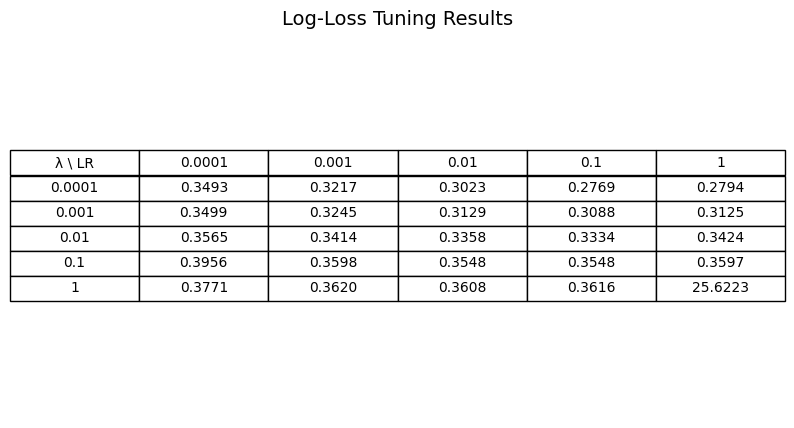

In [145]:
def display_log_loss_results(log_loss_scores, learning_rates, reg_cons):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis('tight')
    ax.axis('off')

    header = ["λ \\ LR"] + [str(lr) for lr in learning_rates]
    table_data = [header]
    for i, reg in enumerate(reg_cons):
        row = [str(reg)] + [f"{log_loss_scores[j, i]:.4f}" for j in range(len(learning_rates))]
        table_data.append(row)

    table = ax.table(cellText=table_data, cellLoc='center', loc='center')
    table.scale(1, 1.5)

    plt.title("Log-Loss Tuning Results", fontsize=14)
    plt.show()


display_log_loss_results(log_loss_scores, learning_rates, reg_cons)


In [146]:
min_idx = np.unravel_index(np.argmin(log_loss_scores), log_loss_scores.shape)
best_learning_rate = learning_rates[min_idx[0]]
best_reg_cons = reg_cons[min_idx[1]]

print(f'Best Learning Rate: {best_learning_rate:.4f}')
print(f'Best Regularization Constant: {best_reg_cons:.4f}')

Best Learning Rate: 0.1000
Best Regularization Constant: 0.0001


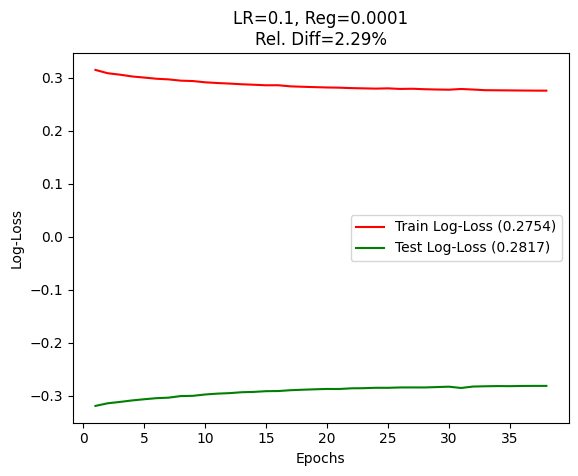

In [147]:
best_model = RidgeLogisticRegression()
best_train_loss_history, best_test_loss_history = best_model.fit(
    X_bank_train, y_bank_train, X_bank_test, y_bank_test,
    initial_learning_rate=best_learning_rate,
    regularization_constant=best_reg_cons,
    i_max=200, batch_size=50)

relative_difference = abs(best_train_loss_history[-1] - best_test_loss_history[-1]) / best_train_loss_history[-1]

plt.plot(range(1, len(best_train_loss_history) + 1), best_train_loss_history,
         label=f'Train Log-Loss ({best_train_loss_history[-1]:.4f})', color='red')

plt.plot(range(1, len(best_test_loss_history) + 1), -np.array(best_test_loss_history),
         label=f'Test Log-Loss ({best_test_loss_history[-1]:.4f})', color='green')

plt.xlabel('Epochs')
plt.ylabel('Log-Loss')
plt.legend()

plt.title(f'LR={best_learning_rate}, Reg={best_reg_cons}\nRel. Diff={relative_difference:.2%}')
plt.show()
plt.close()